In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [32]:
img_size = (256, 256)

In [33]:
manga_data = tf.keras.utils.image_dataset_from_directory("archive", image_size=img_size, color_mode='grayscale')

Found 31771 files belonging to 1 classes.


In [34]:
manga_data_iterator = manga_data.as_numpy_iterator()

In [35]:
manga_batch = manga_data_iterator.next()

In [36]:
print(manga_batch[0].shape)

(32, 256, 256, 1)


In [37]:
photo_data = tf.keras.utils.image_dataset_from_directory("archive2", image_size=img_size, color_mode='grayscale')
photo_data_iterator = photo_data.as_numpy_iterator()

Found 31783 files belonging to 1 classes.


In [38]:
photo_batch = photo_data_iterator.next()

In [39]:
photo_batch[0].shape

(32, 256, 256, 1)

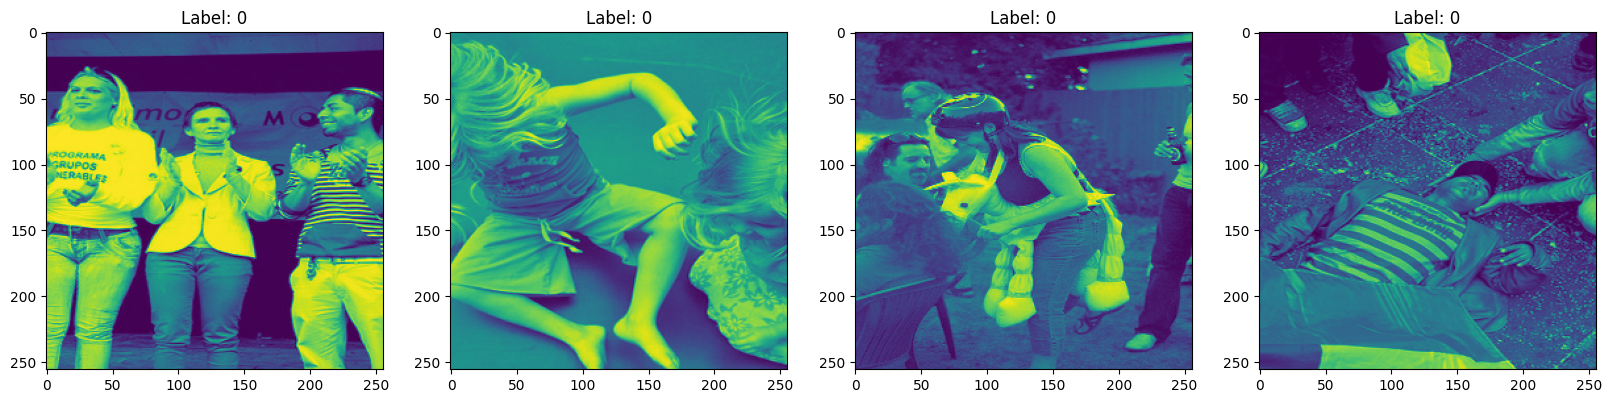

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(photo_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {photo_batch[1][idx]}")

## Preprocess

In [41]:
# normalizing the photos and manga data
manga_data = manga_data.map(lambda x,y: (x/255, y))
photo_data = photo_data.map(lambda x,y: (x/255, y))

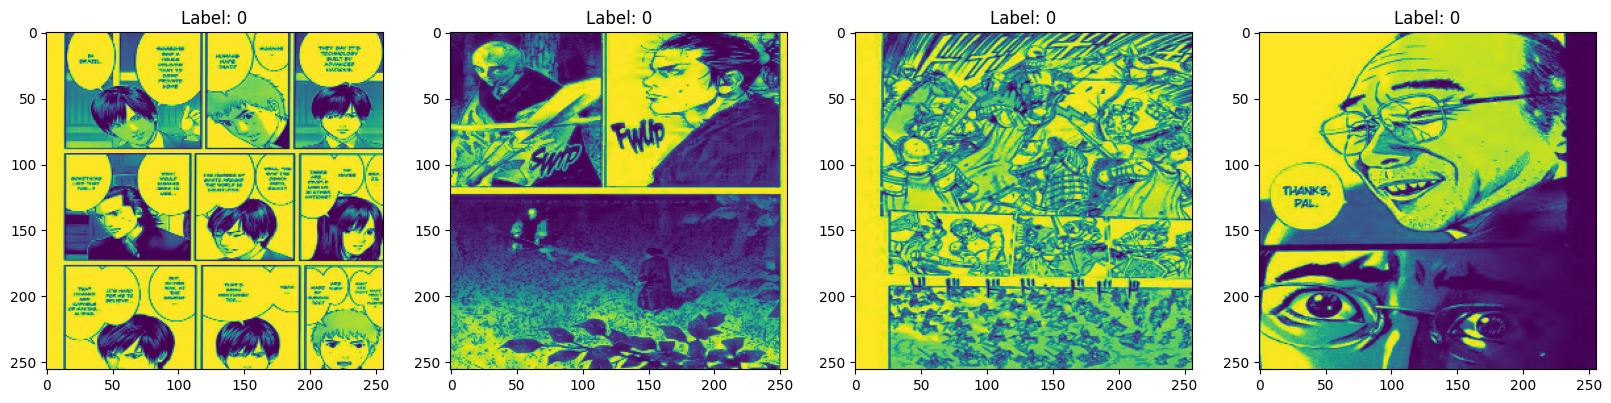

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(manga_batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f"Label: {manga_batch[1][idx]}")

## Discriminator

In [48]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', input_shape=[256, 256, 1]))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [49]:
D = make_discriminator()
D.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


 conv2d_7 (Conv2D)           (None, 128, 128, 16)      160       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 64, 64, 16)        0         
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 16)        0         
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65537     
          

In [66]:
#create generator with the output size as the input size of the discriminator
def make_generator():
    # model = tf.keras.Sequential()
    # model.add(tf.keras.layers.Dense(16 * 115 * 165, input_dim=100))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Reshape((115, 165, 16)))
    # model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    # model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # model.add(tf.keras.layers.Conv2D(3, (7, 7), activation='sigmoid', padding='same'))

    # write the model here that gives the ouput of the same size as the input of the discriminator
    # output size should be (256, 256, 1)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(16 * 128 * 128, input_dim=100))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((128, 128, 16)))
    model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2DTranspose(16, (4, 4), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Conv2D(1, (7, 7), activation='sigmoid', padding='same'))
    model.add(tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2), padding='same'))

    return model

In [67]:
G = make_generator()
G.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 262144)            26476544  
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 262144)            0         
                                                                 
 reshape_12 (Reshape)        (None, 128, 128, 16)      0         
                                                                 
 conv2d_transpose_22 (Conv2  (None, 256, 256, 16)      4112      
 DTranspose)                                                     
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 256, 256, 16)      0         
                                                                 
 conv2d_transpose_23 (Conv2  (None, 512, 512, 16)      4112      
 DTranspose)                                         

In [68]:
def define_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [1]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset[0].shape[0], n_samples)
    X = dataset[0]
    y = np.ones((n_samples, 1))
    return X, y
    # return 1, 0

def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))

    # save the image
    for i in range(n_samples):
        plt.imsave(f"generated_images/{i}.png", X[i].reshape(256, 256), cmap='gray')

    return X, y

In [2]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=64):
    batch_per_epoch = len(dataset)
    half_batch = int(n_batch / 2)
    data_itr = dataset.as_numpy_iterator()
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(data_itr.next(), half_batch)
            # print("hi")
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # print("d_loss1: ", d_loss1)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # print("hi3")
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # print("d_loss2: ", d_loss2)

            X_gan = generate_latent_points(latent_dim, n_batch)
            # print("hi5")
            y_gan = np.ones((n_batch, 1))

            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            print(f"Epoch: {i}, Batch: {j}, d_loss1: {d_loss1}, d_loss2: {d_loss2}, g_loss: {g_loss}")
            
        # save the generator model for every epoch
        g_model.save(f"generator_model/generator_model_{i}.h5")

In [ ]:
train(G, D, define_gan(G, D), manga_data, 100, 64)